### Do the measurement of the line peaks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as c
from astropy import constants as const
from astropy.io import fits
import emcee, corner

In [2]:
## FITS data
hdu = fits.open("goodsn-42-G141_01060.2D.fits")
sci_d = hdu['SCI'].data
sci_h = hdu['SCI'].header
wl = np.linspace(1*sci_h['CRVAL1'],1*sci_h['CRVAL1'] + ((sci_h['NAXIS1']-1)*sci_h["CD1_1"]),sci_h['NAXIS1'])

In [3]:
wl[0],wl[-1]

(10167.39524851952, 17195.01924107872)

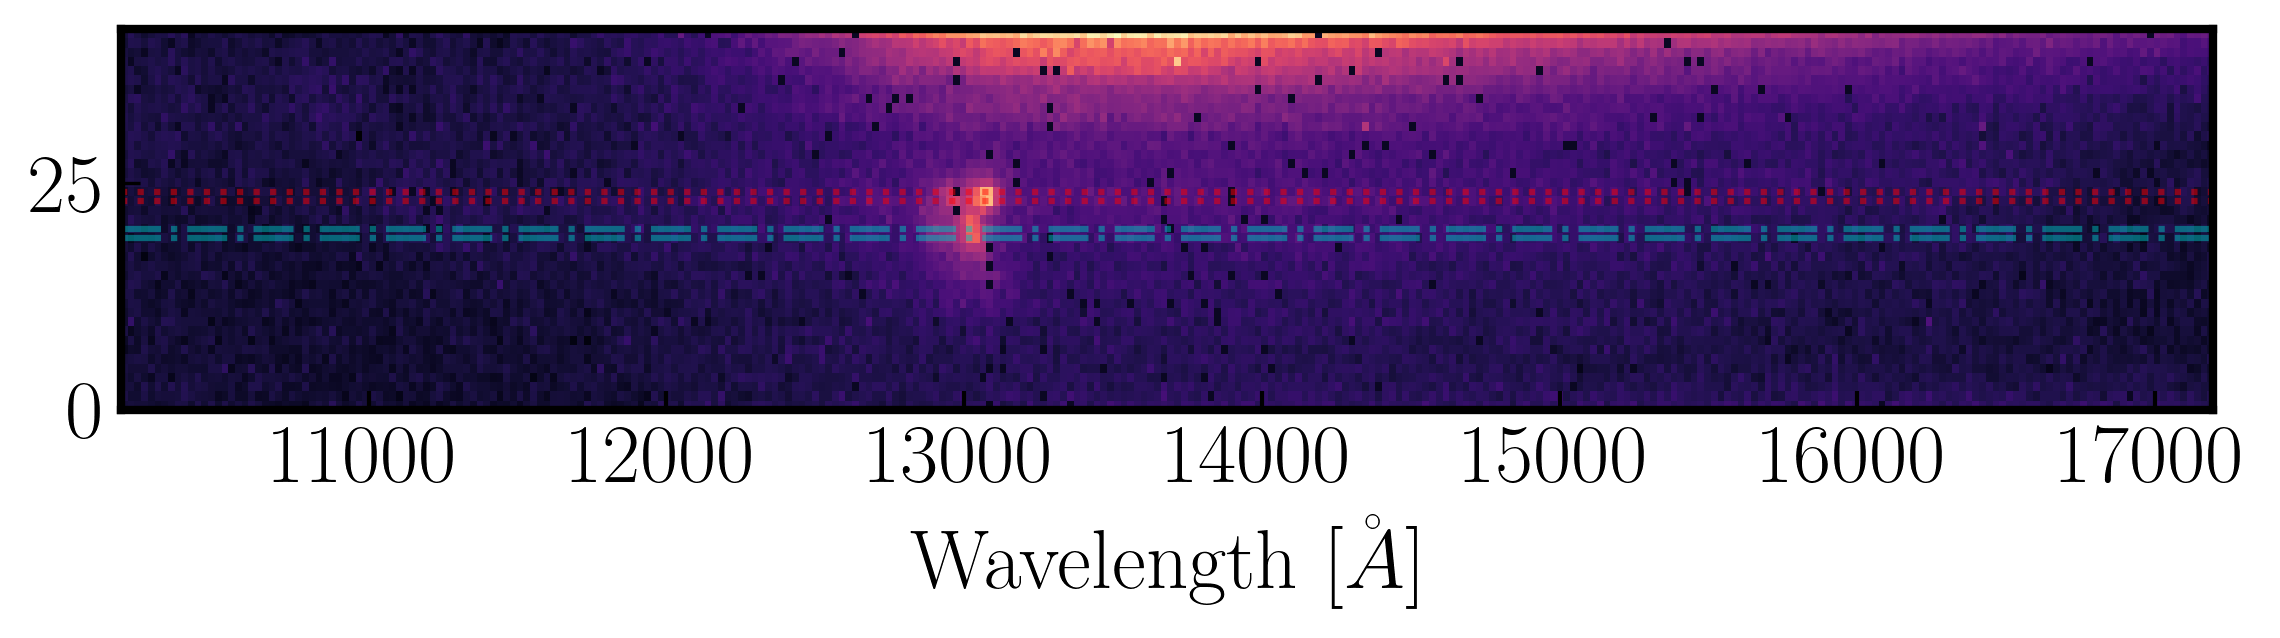

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(sci_d,origin='lower',extent=[wl[0],wl[-1],0,42])
ax.set_aspect(sci_h['NAXIS1']/sci_h['NAXIS2']*4)
ax.set_xlabel('Wavelength [$\AA$]')
ax.axhline(24,c='r',ls=':',alpha=0.5)
ax.axhline(23,c='r',ls=':',alpha=0.5)
ax.axhline(20,c='c',ls='-.',alpha=0.5)
ax.axhline(19,c='c',ls='-.',alpha=0.5)
plt.show()

In [5]:
## These are the rest frame line values for OIII
O3_A = 5006.843 ## in angstroms!
O3_B= 4958.911 ## in angstroms!
z = 1.6095

## Convert to observer frame
O3_A_obs = O3_A*(1+z)
O3_B_obs = O3_B*(1+z)

## Observed peaks of OIII line
ns = np.nanmean(hdu['SCI'].data[23:25,110:140],axis=0)
ss = np.nanmean(hdu['SCI'].data[19:21,110:140],axis=0)
wl_s = wl[110:140]

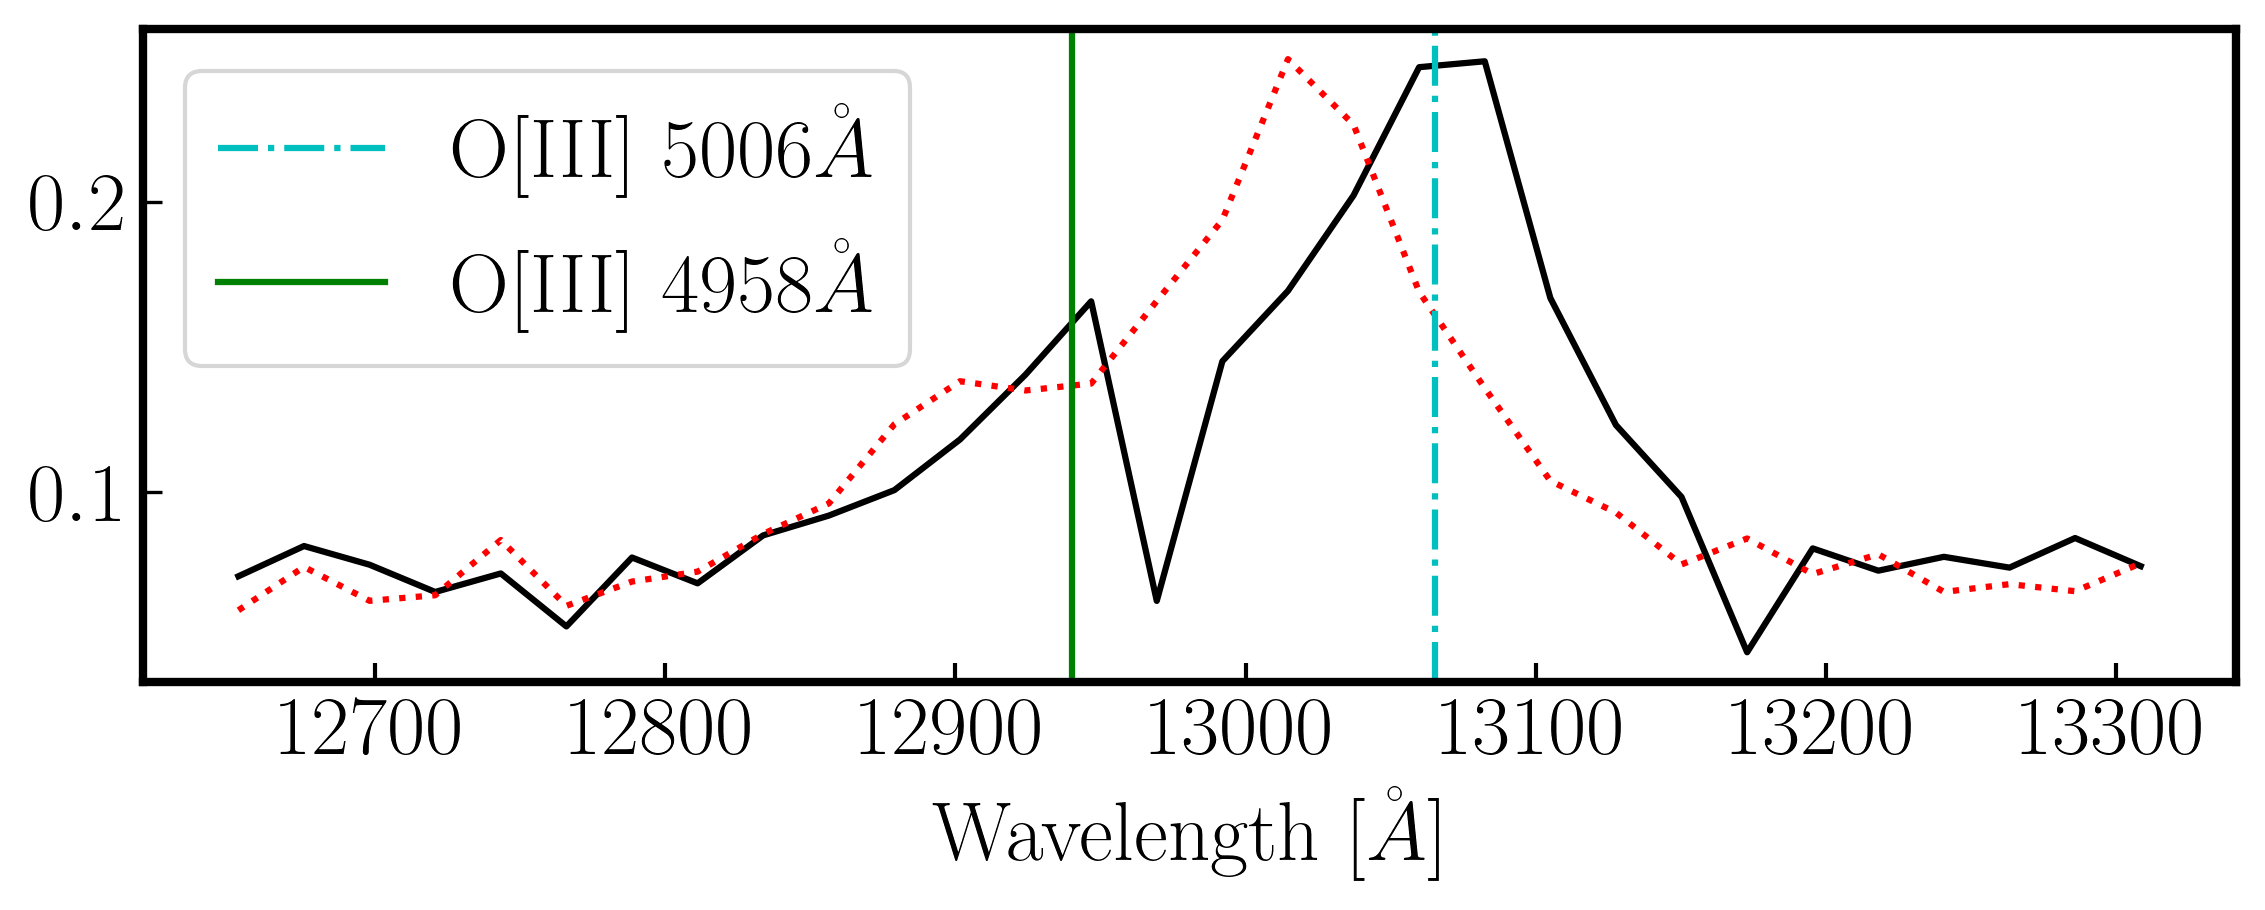

In [6]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(wl[110:140],ns,'k-')
ax.plot(wl[110:140],ss,'r:')
ax.axvline(O3_A_obs,ls='-.',c='c',label="O[III] 5006$\AA$")
ax.axvline(O3_B_obs,ls='-',c='g',label="O[III] 4958$\AA$")
ax.set_xlabel('Wavelength [$\AA$]')
ax.set_aspect(1000)
ax.legend()

## We did the fitting so this is just me testing
nsp_wl = wl_s[np.where(ns==ns.max())]
ssp_wl = wl_s[np.where(ss==ss.max())]

### Calculate the velocities

In [7]:
print("Obs frame OIII lines wavelengths: %.3f, %.3f [Angstroms]"%(O3_A_obs,O3_B_obs))

def doppler(wl,wl_0):
    return c.c*((wl-wl_0)/wl_0)[0]

ns_v = doppler(wl=nsp_wl,wl_0=O3_A_obs)
ss_v = doppler(wl=ssp_wl,wl_0=O3_A_obs)
vdiff = ns_v-ss_v
vr=np.abs(ss_v/ns_v)

print("Velocities: North = %.2f km/s, South = %.2f km/s"%(ns_v/1e3,ss_v/1e3))
print("Velocity difference v1-v2 = %.2f km/s"%(vdiff/1e3))
print("Velocity ratio v2/v1 = %.2f"%vr)

Obs frame OIII lines wavelengths: 13065.357, 12940.278 [Angstroms]
Velocities: North = 390.85 km/s, South = -1164.65 km/s
Velocity difference v1-v2 = 1555.50 km/s
Velocity ratio v2/v1 = 2.98


### Calculate the model for the B-SMBH

Going to use the following model:

$$ v_1 + v_2 = |v_1|-|v_2| = \left(\frac{2\pi m_\mathrm{tot}\sin^3(i)G}{P}\right)^{1/3}$$

Reduce dimensions:

v1 + v2 ~ $10^{6}$, G ~ $10^{-11}$,  2pi ~ $10^{0}$, 1/P ~ $10^{-13}$, mtot ~ $10^{38}$ kg

In log10 space:

$$\log(v_1 + v_2) = (1/3)\left[\log{2\pi G} + \log(m_\mathrm{tot}) + \log(\sin^3(i)) - \log(P)\right]$$

^ the $v_1$ - $v_2$ is the same as the simple model that RD used it's just that the signs of the velocities are reversed

In [8]:
## define the model first
#def kepler_model(theta):
#    m1,m2,P = theta
#    sin3i = 2/3
#    return np.log10(((2*c.pi*c.G*sin3i*(m1+m2))/P)**(1/3))

#def kepler_model_log(theta):
#    m1,m2,logP,sin3i = theta
#    return (1/3)*(np.log10(2*c.pi*c.G)+np.log10(m1+m2)+np.log10(sin3i)-logP-np.log10(const.M_sun.value))

In [9]:
def lnlike(theta, dv, dv_err):
    return -0.5 * np.sum(((dv - kepler_model(theta))/dv_err) ** 2)

def lnlike_log(theta, dv, dv_err):
    return -0.5 * np.sum(((dv - kepler_model_log(theta))/dv_err) ** 2)

In [10]:
def lnprior(theta):
    m1,m2,P = theta
    if 1 < m1 < 1e10 and  1 < m2 < 1e10 and  1 < P < 1e11:
        return 0.0
    return -np.inf

def lnprior_log(theta,vr):
    m1,m2,logP,sin3i = theta
    if 0 < m1 < 1e20 and  0 < m2 < 1e20 and  0 < logP < 15 and 0 < sin3i < 1 and vr*0.9 <m1/m2 < vr*1.1 :
        return 0.0
    return -np.inf

In [11]:
def lnprob(theta, dv, dv_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, dv, dv_err)

def lnprob_log(theta, dv, dv_err):
    lp = lnprior_log(theta,vr=2.98)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_log(theta, dv, dv_err)

In [12]:
nwalkers = 512
niter = 10000
initial = np.array([1e8, 1e8, 1e5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [13]:
nwalkers_log = 512
niter_log = 10000
initial_log = np.array([1e8, 1e8, 5, 0.5])
ndim = len(initial_log)
p0 = [np.array(initial_log) + 100 * np.random.randn(ndim) for i in range(nwalkers)]

In [14]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data,moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ])

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter,)

    return sampler, pos, prob, state

In [15]:
scaler = (const.M_sun.value)**(1/3)
data = (vdiff/scaler,vdiff/10/scaler)

data_log = (np.log10(vdiff)-np.log10(const.M_sun.value),np.log10(vdiff)-np.log10(const.M_sun.value))

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob_log,data)

Running burn-in...


/usr/local/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


Text(0.5, 0, 'step number')

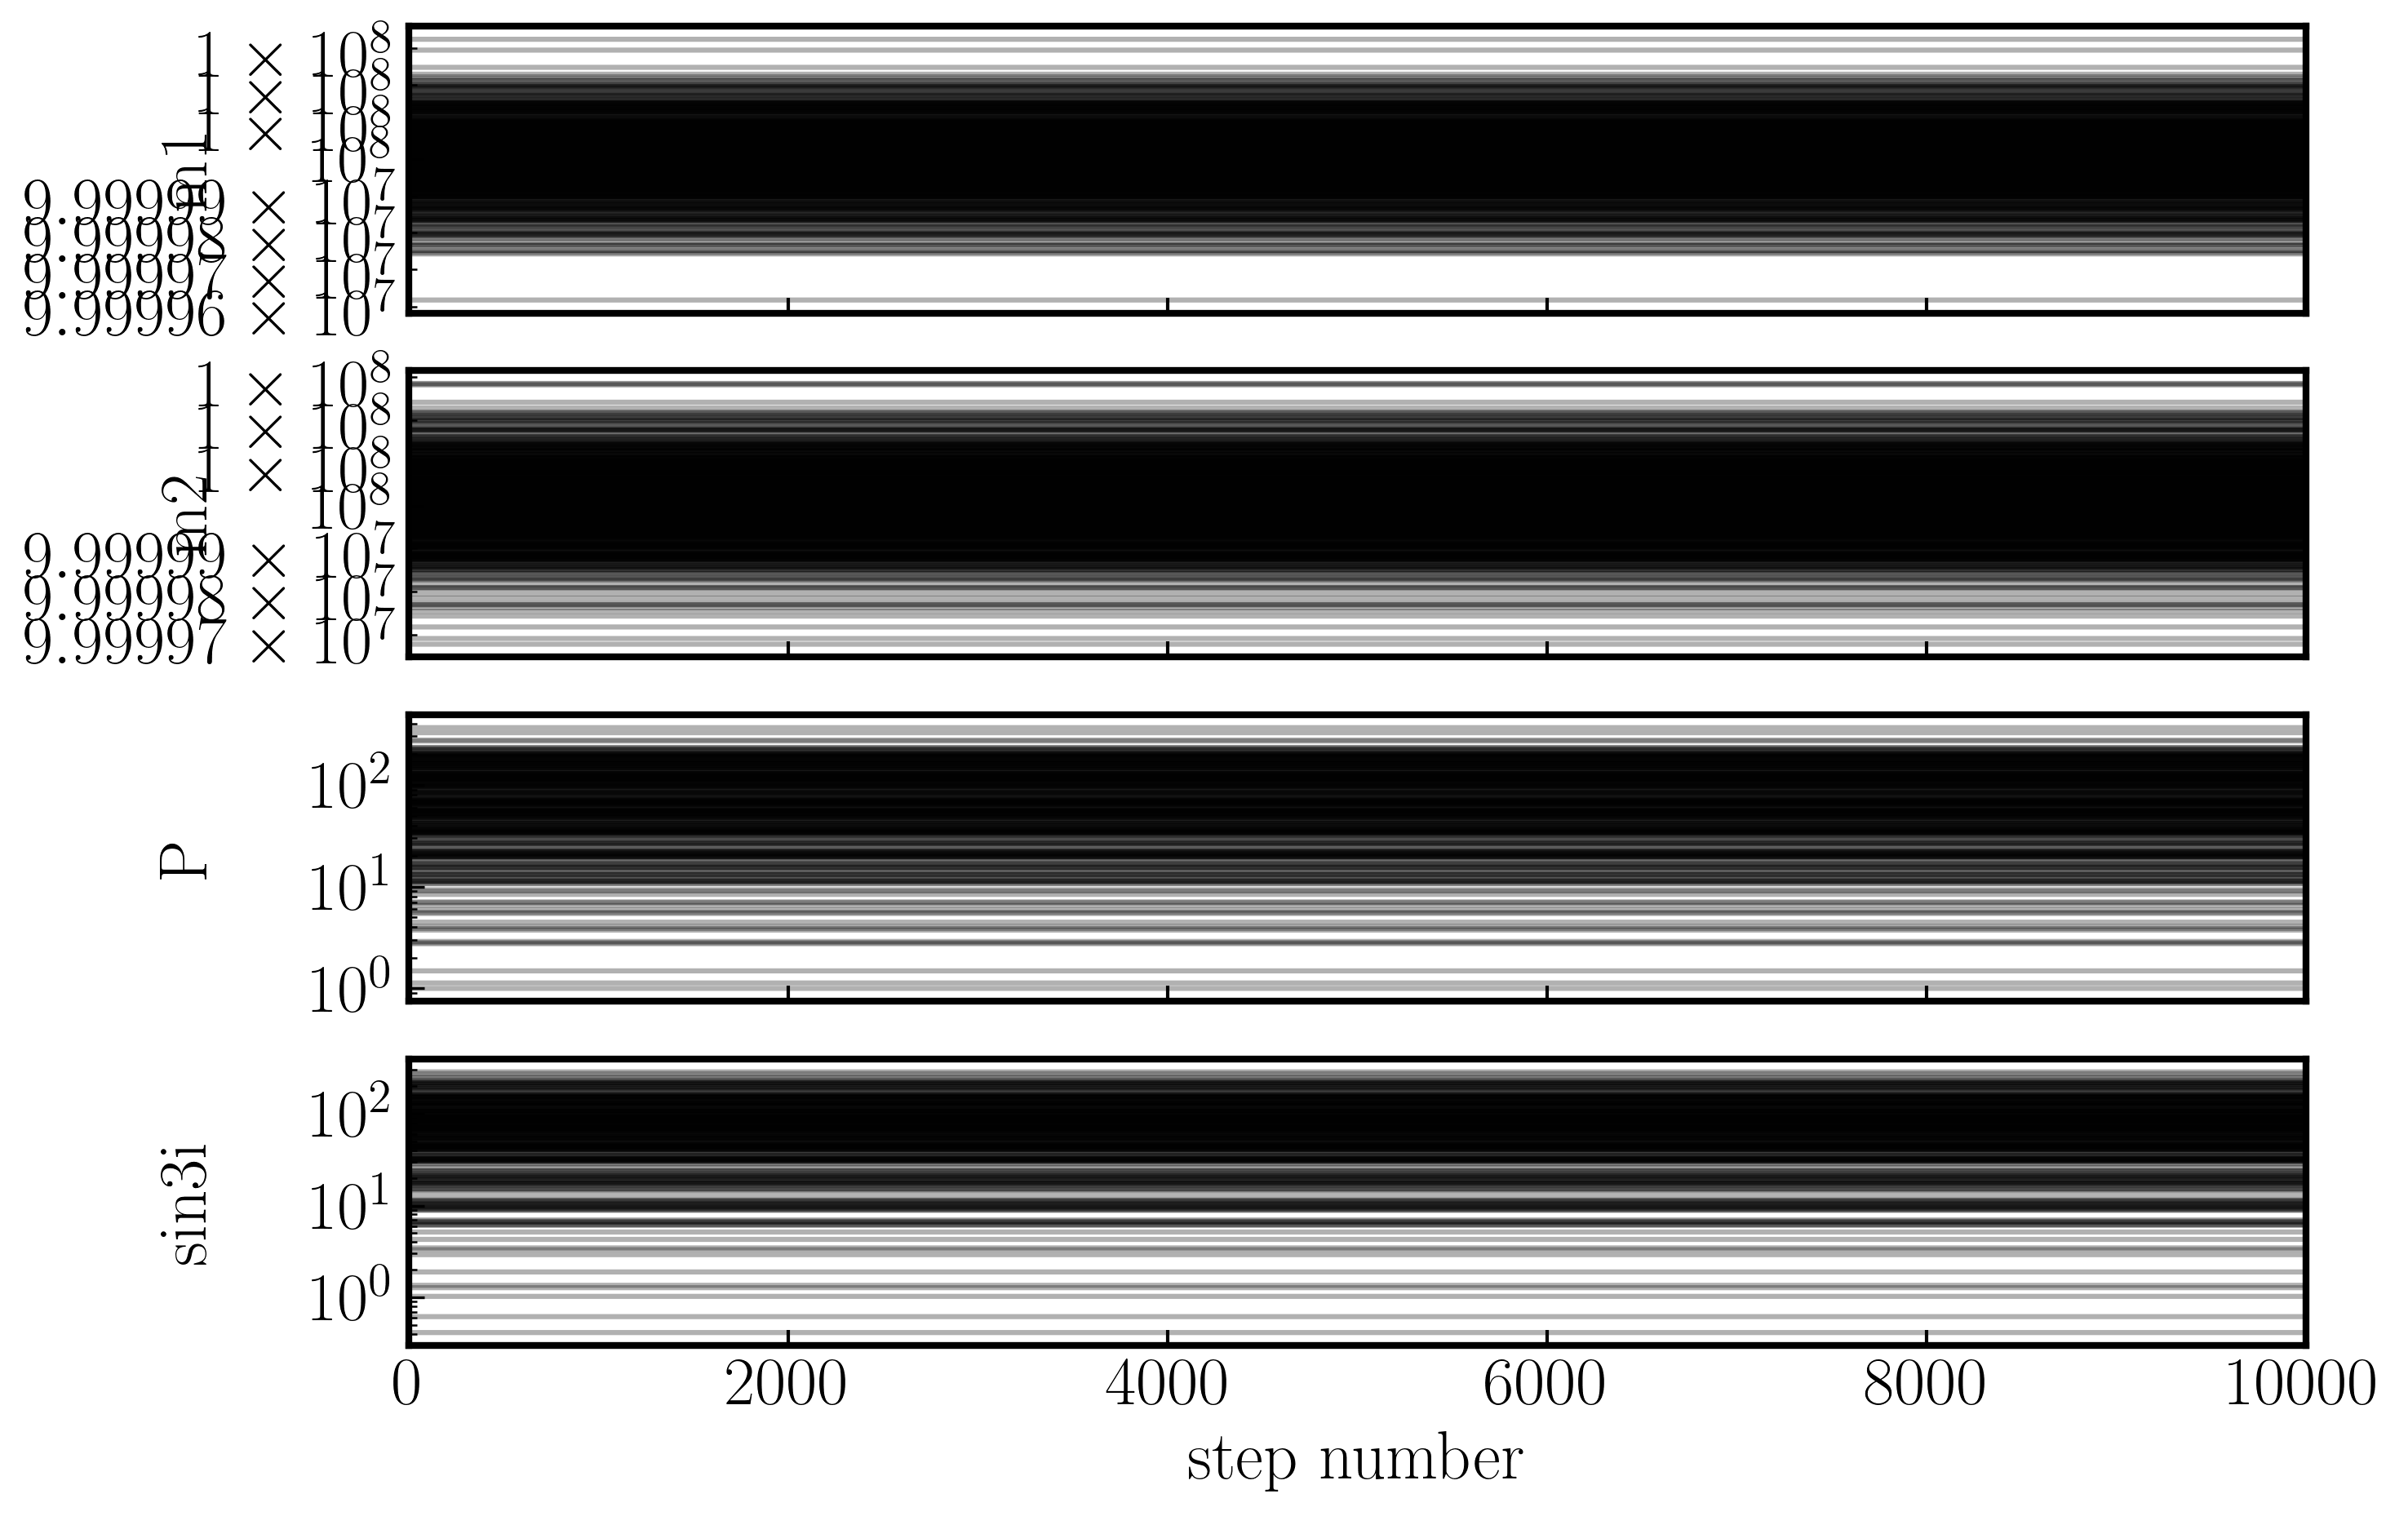

In [16]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m1", "m2", "P", "sin3i"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3,rasterized=True)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_yscale("log")

axes[-1].set_xlabel("step number")

In [17]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 1.00000104e+08,  1.00000142e+08, -8.20687183e+01,  1.42504260e+02])

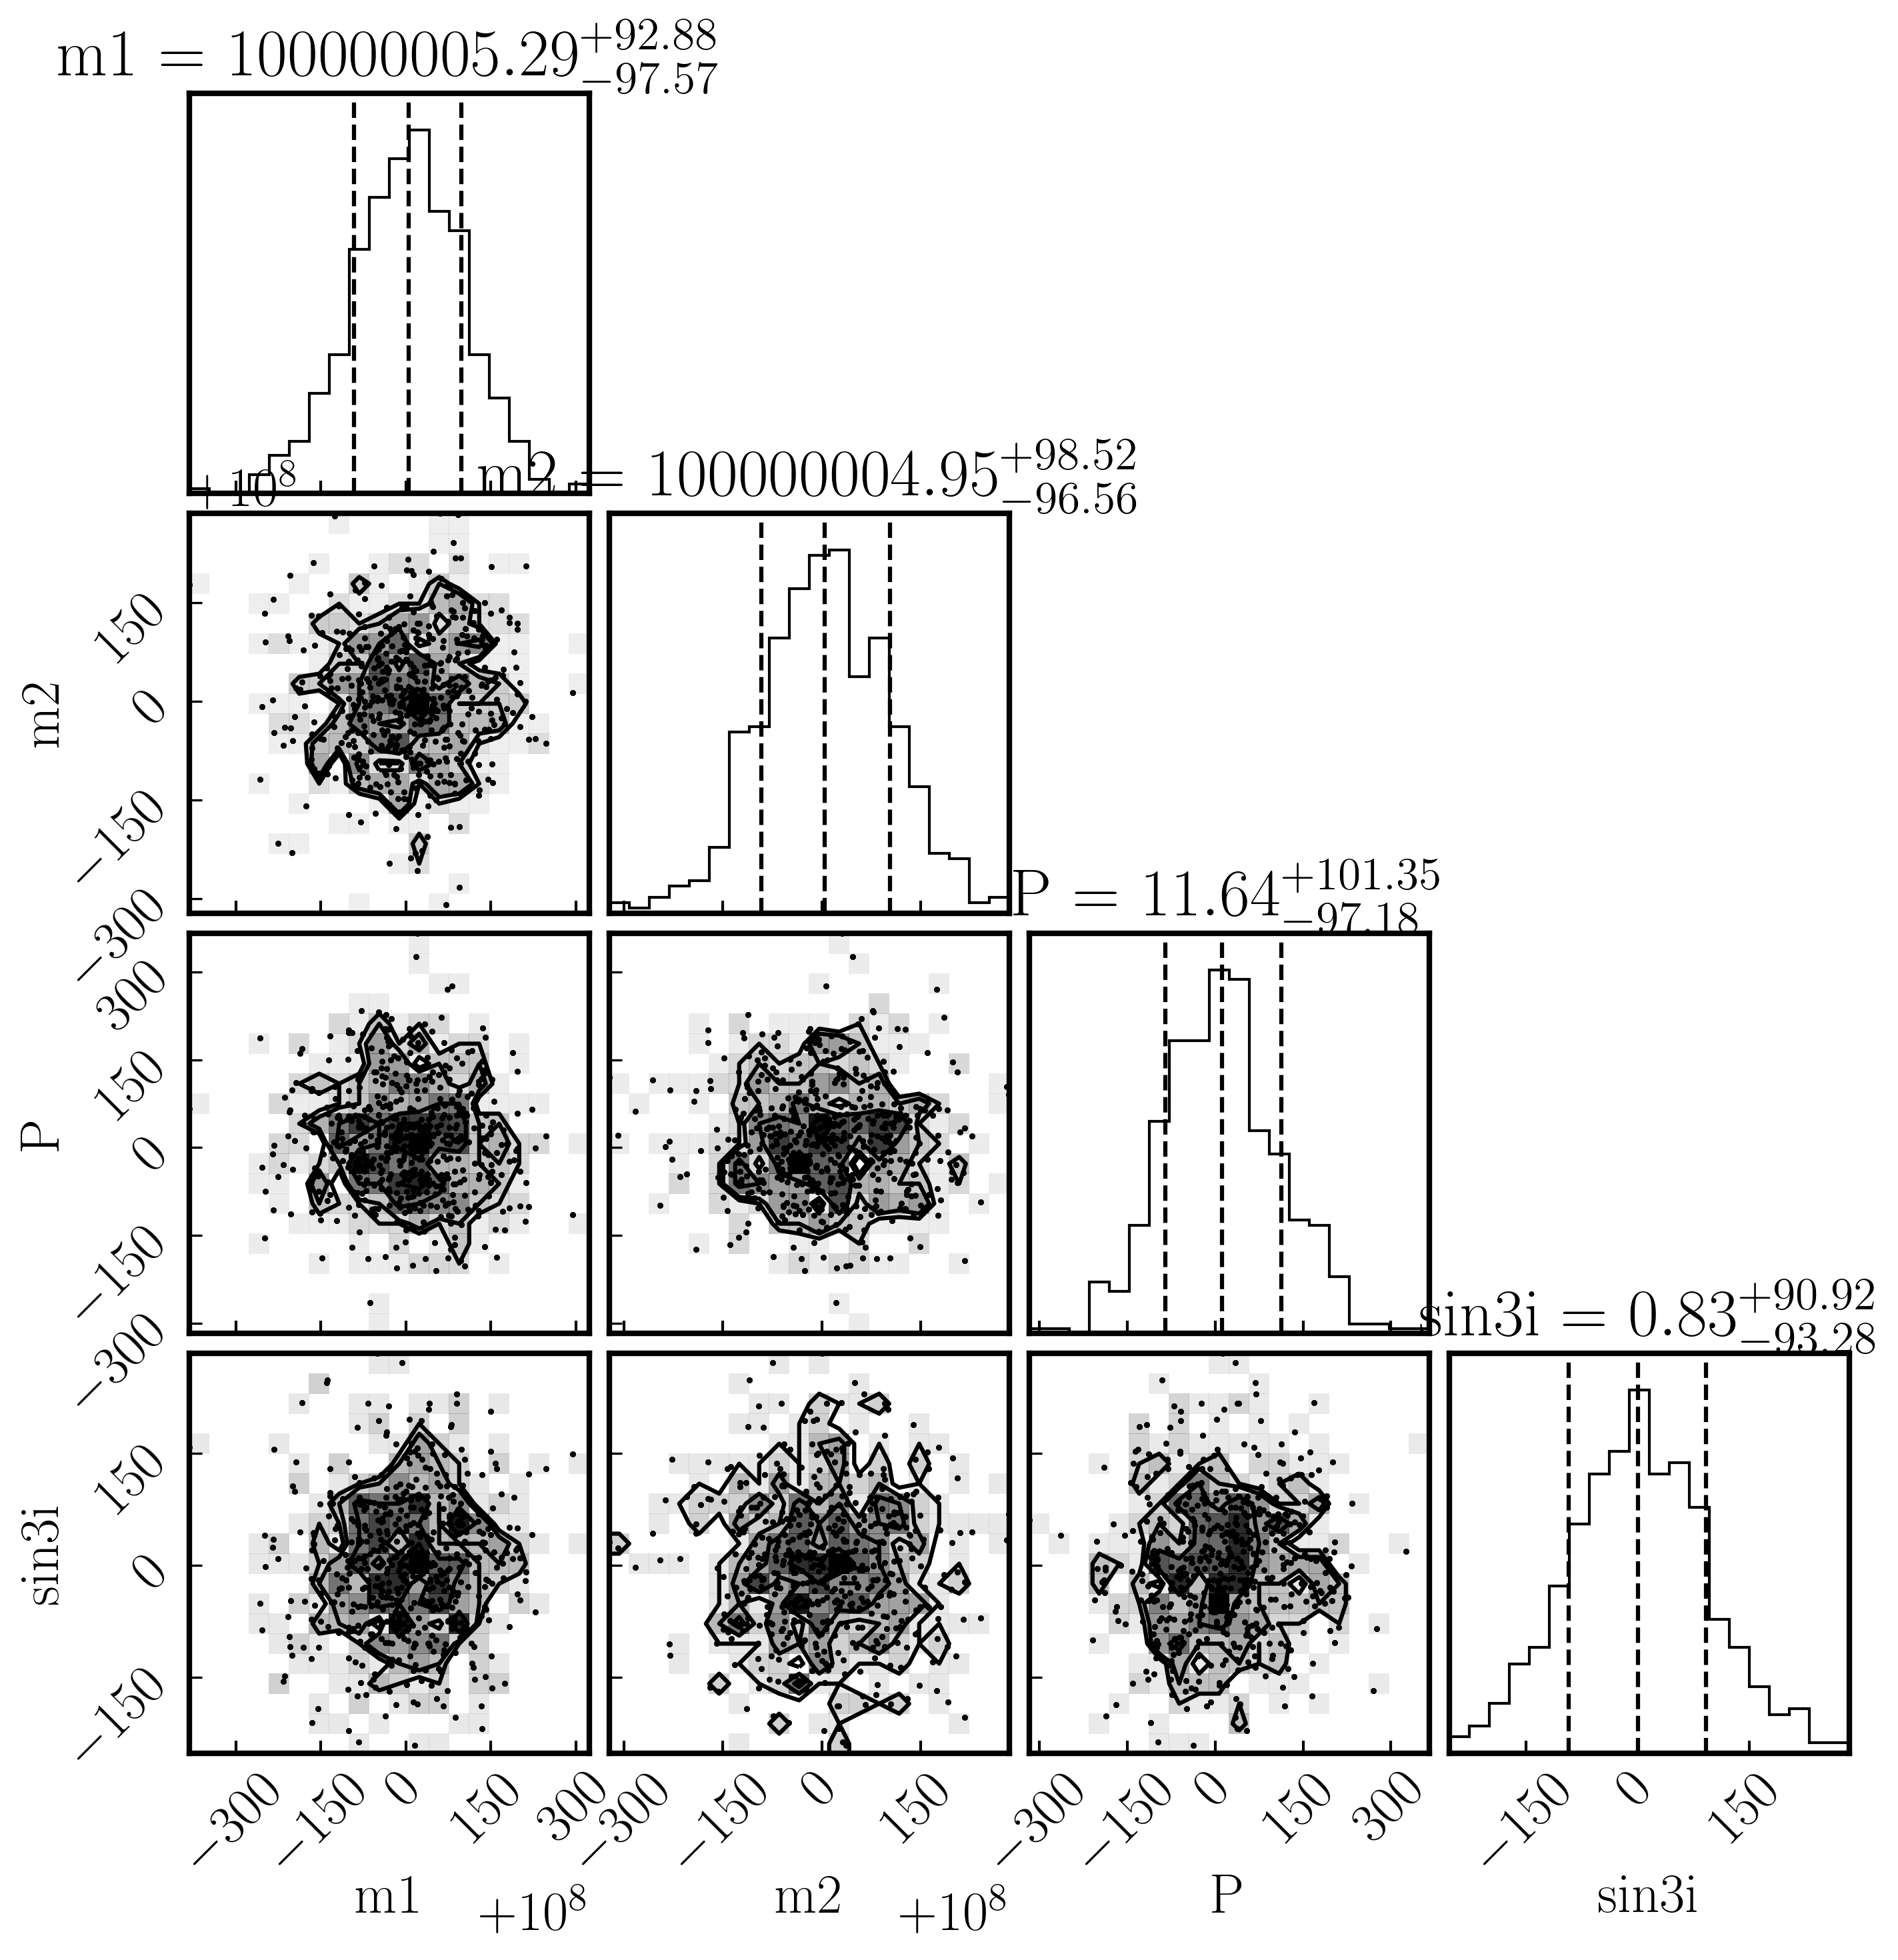

In [18]:
labels = ["m1","m2","P","sin3i"]
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

### mcmc part 2

In [19]:
nthreads = 3

In [20]:
def kepler(*p):
    return np.log10(((2*c.pi*c.G*p[3]*(p[0]+p[1]))/p[2])**(1/3))

def lnlike(theta, y, yerr):
    m1,m2,P,sin3i,lnf = theta
    model = kepler(theta)
    inv_sigma2 = 1.0 / (yerr**2 + model**2*np.exp(2*lnf))
    return -0.5 * np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2))

def lnprior(theta):
    m1,m2,P,sin3i, lnf = theta
    if 0 < m1 < 1e20 and  0 < m2 < 1e20 and  0 < P < 15 and 0 < sin3i < 1 and 0 < lnf < 1e10:
        return 0.0
    return -np.inf

def lnprob(theta, y, yerr):
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, y, yerr)

nwalkers = 1024
niter = 100000
initial = np.array([1e8, 1e8, 1e5, 0.5, 1e5])
ndim = len(initial)
pos = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [21]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args=(vdiff/scaler,vdiff/10/scaler),
                                threads=nthreads,moves=[(emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(gammas=17), 0.2)])
sampler.run_mcmc(pos, niter)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

/usr/local/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


In [ ]:
fig = corner.corner(samples,
                    labels=["m1", "m2", "P", "sin3i","lnf"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True)